In [106]:
### Modules ### 
import pandas as pd
import numpy as np

# algumas bibliotecas para data-viz:
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

### GCP Modules ### 
from google.cloud import storage
import gcsfs
import os
fs = gcsfs.GCSFileSystem(project='awaricripto')
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/Users/gabrielgomes/Downloads/awaricripto-5cfe64a9c26d.json"

# Bibliotecas para Standardization 
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

### Read main50 into the notebook | Define random5

In [2]:
with fs.open('main50/main50.csv') as f:
    main50 = pd.read_csv(f, index_col = 'Unnamed: 0')

### Define read_csv(id) function


In [79]:
def read_csv(id): 
    path = f'/Users/gabrielgomes/ProjetoAwariCripto/Updating workflow/updated_CSVs/{id}_updated.csv'
    id_ts = pd.read_csv(path, index_col = 'Unnamed: 0')
    id_ts.set_index('dates', inplace=True)
    id_ts.index = pd.to_datetime(id_ts.index, format='%d-%m-%Y')
    return id_ts

## Vizualize growth for all features
* First we must scale-down the features for comparisson/correlation analysis, we will test results for 4 different scalers
    * First  | Hand-made scaler, log with base e
    * Second | Standard Scaler
    * Third  | MinMax Scaler
    * Fourth | Robust Scaler

In [132]:
# First | Natural Log
def logScaler(id, features, days):
    '''For a given id, and a given day-range, returns a new dataframe with 100-standard version for each of the chosen features.
    '''
    # Name 
    name = 'Log Scaler'
    
    # read it
    id_ts = read_csv(id)
    
    # Define range and features
    id_ts = id_ts[features].head(days)    
    
    # Create an empty df
    stand_ts = pd.DataFrame()
    
    # Iterate for columns 
    for col in id_ts.columns:
        scale = id_ts[col][-1]
        stand = id_ts[col]/scale * 100
        stand = np.log(stand) * (100/np.log(100))
        stand_ts[col]=stand
        
        
    return stand_ts, name

In [133]:
# Second | Standard Scaler
def standardScaler(id, features, days):
    '''For a given id, and a given day-range, returns a new dataframe with Standard Scaler version for each of the chosen features.
    '''
    # Name 
    name = 'Standard Scaler'
    
    # read it
    id_ts = read_csv(id)
    
    # Define range and features
    id_ts = id_ts[features].head(days)    
    
    # Assign model
    standard_scaler = StandardScaler()
    
    # Fit_transform the model
    id_ts_stand = standard_scaler.fit_transform(id_ts)
    
    # Define dataframe 
    id_ts_stand = pd.DataFrame(data=id_ts_stand, columns=id_ts.columns, index=id_ts.index)
    
    # Return dataframe 
    return id_ts_stand, name
    

In [134]:
# Third | MinMax Scaler
def mmScaler(id, features, days):
    '''For a given id, and a given day-range, returns a new dataframe with MinMax Scaler version for each of the chosen features.
    '''
    # Name 
    name = 'MinMax Scaler'
    
    # read it
    id_ts = read_csv(id)
    
    # Define range and features
    id_ts = id_ts[features].head(days)    
    
    # Assign model
    min_max_scaler = MinMaxScaler()
    
    # Fit_transform the model
    id_ts_transformed = min_max_scaler.fit_transform(id_ts)
    
    # Define dataframe 
    id_ts_transformed = pd.DataFrame(data=id_ts_transformed, columns=id_ts.columns, index=id_ts.index)
    
    # Return dataframe 
    return id_ts_transformed, name

In [135]:
# Fourth | robust Scaler
def rbstScaler(id, features, days):
    '''For a given id, and a given day-range, returns a new dataframe with Robust Scaler version for each of the chosen features.
    '''
    # Name 
    name = 'Robust Scaler'
    
    # read it
    id_ts = read_csv(id)
    
    # Define range and features
    id_ts = id_ts[features].head(days)    
    
    # Assign model
    robust_scaler = RobustScaler()
    
    # Fit_transform the model
    id_ts_robust = robust_scaler.fit_transform(id_ts)
    
    # Define dataframe 
    id_ts_robust = pd.DataFrame(data=id_ts_robust, columns=id_ts.columns, index=id_ts.index)
    
    # Return dataframe 
    return id_ts_robust, name

### Features for analysis

In [168]:
linear_features = ['twitter_followers','reddit_subs','github_subs','forks',
                   'stars','total_issues','closed_issues',
                    'pull_rqst_merged', 'pull_request_contributors',
                    'usd_cp']

behav_features = [ 'reddit_avg_posts_48h',
                   'reddit_avg_comments_48h',
                   'usd_tv','usd_cp']

selected_features = ['reddit_avg_posts_48h',
                     'usd_cp']

all_features = (linear_features + behav_features)
all_features.remove('usd_cp')

### Standardization Comparisson function

In [265]:
def compare(id, days, period):
    
    # Log scaler
    log = logScaler(id, selected_features, days)
    log_cp = log[0]['usd_cp']
    log_reddit = log[0]['reddit_avg_posts_48h']
    
    #decompose
    decomposed_price = seasonal_decompose(log_cp, period=period)
    decomposed_reddit = seasonal_decompose(log_reddit, period=period)
    
    # Plot
    decomposed_reddit.trend.plot(figsize=(20,8), title=log[1])
    decomposed_price.trend.plot()
    #decomposed_reddit.observed.plot()
    #decomposed_price.observed.plot()
    plt.legend(['reddit_posts_trend', 'price_trend'])#, 'reddit_avg_posts_48h','price'])
    plt.show()

    
    # Standard scaler
    Standard = standardScaler(id, selected_features, days)
    Standard_cp = Standard[0]['usd_cp']
    Standard_reddit = Standard[0]['reddit_avg_posts_48h']
    
    #decompose
    decomposed_price = seasonal_decompose(Standard_cp, period=period)
    decomposed_reddit = seasonal_decompose(Standard_reddit, period=period)
    
    # Plot
    decomposed_reddit.trend.plot(figsize=(20,8), title=Standard[1])
    decomposed_price.trend.plot()
    #decomposed_reddit.observed.plot()
    #decomposed_price.observed.plot()
    plt.legend(['reddit_posts_trend', 'price_trend'])#, 'reddit_avg_posts_48h','price'])
    plt.show()
    
    
    # MinMax scaler
    mm = mmScaler(id, selected_features, days)
    mm_cp = mm[0]['usd_cp']
    mm_reddit = mm[0]['reddit_avg_posts_48h']
    
    #decompose
    decomposed_price = seasonal_decompose(mm_cp, period=period)
    decomposed_reddit = seasonal_decompose(mm_reddit, period=period)
    
    # Plot
    decomposed_reddit.trend.plot(figsize=(20,8), title=mm[1])
    decomposed_price.trend.plot()
    #decomposed_reddit.observed.plot()
    #decomposed_price.observed.plot()
    plt.legend(['reddit_posts_trend', 'price_trend'])#, 'reddit_avg_posts_48h','price'])
    plt.show()
    
    
    # Robust scaler
    rbst = rbstScaler(id, selected_features, days)
    rbst_cp = rbst[0]['usd_cp']
    rbst_reddit = rbst[0]['reddit_avg_posts_48h']
    
    #decompose
    decomposed_price = seasonal_decompose(rbst_cp, period=period)
    decomposed_reddit = seasonal_decompose(rbst_reddit, period=period)
    
    # Plot
    decomposed_reddit.trend.plot(figsize=(20,8), title=rbst[1])
    decomposed_price.trend.plot()
    #decomposed_reddit.observed.plot()
    #decomposed_price.observed.plot()
    plt.legend(['reddit_posts_trend', 'price_trend'])#, 'reddit_avg_posts_48h','price'])
    plt.show()

#### Apply for 1 id

In [224]:
# Test coin
main50.sample(1)

,id
20,compound-yearn-finance


In [225]:
random = 'ethereum'

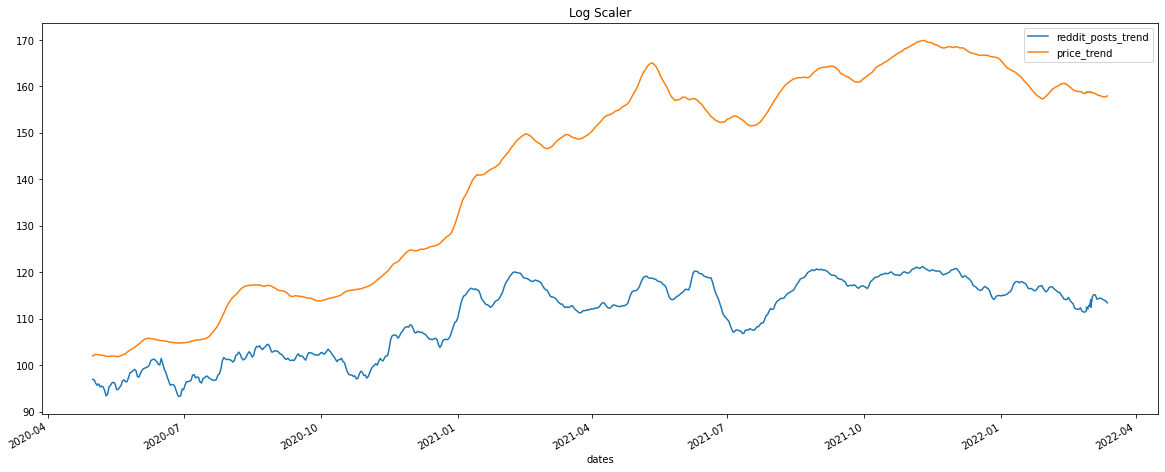

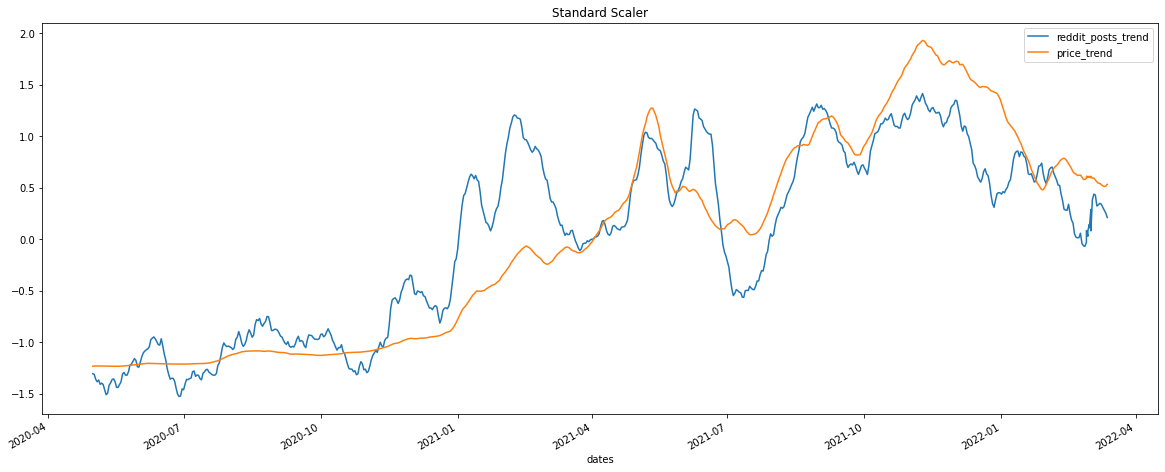

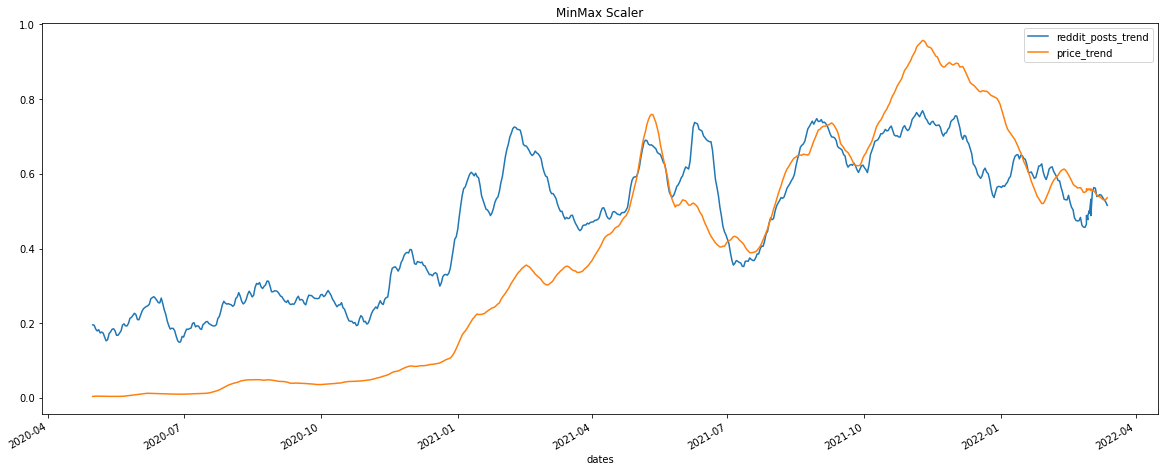

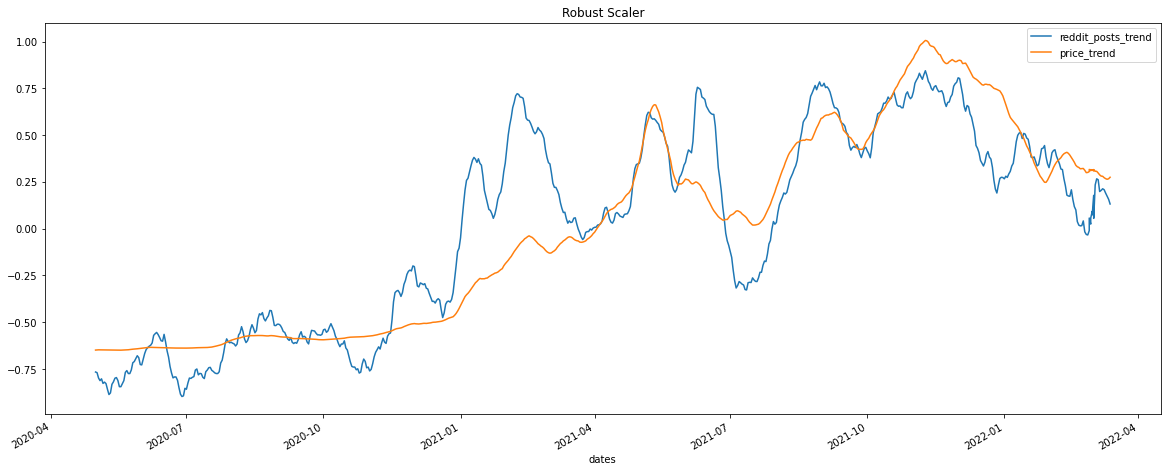

In [266]:
compare(random, 700, 15)

In [267]:
read_csv('solana')

,twitter_followers,reddit_subs,reddit_avg_posts_48h,reddit_avg_comments_48h,forks,stars,github_subs,total_issues,closed_issues,pull_rqst_merged,pull_request_contributors,usd_cp,eur_cp,brl_cp,usd_mc,eur_mc,brl_mc,usd_tv,eur_tv,brl_tv
dates,,,,,,,,,,,,,,,,,,,,
2022-03-20,1546238.0,134870.0,2.91,44.09,1769.0,7643.0,245.0,3763.0,3075.0,16807.0,276.0,92.40,83.51,464.22,2.959841e+10,2.674909e+10,1.486950e+11,1.493437e+09,1.349670e+09,7.502655e+09
2022-03-19,1543822.5,134719.0,3.54,47.73,1766.0,7636.0,245.0,3762.0,3075.0,16806.0,276.0,89.91,81.25,451.67,2.879600e+10,2.602392e+10,1.446639e+11,2.216690e+09,2.003298e+09,1.113610e+10
2022-03-18,1541407.0,134611.0,4.10,60.70,1763.0,7626.0,245.0,3758.0,3071.0,16793.0,275.0,87.97,79.27,443.44,2.848385e+10,2.567076e+10,1.435814e+11,1.939375e+09,1.747686e+09,9.776198e+09
2022-03-17,1539475.5,134491.0,3.91,77.46,1756.0,7621.0,244.0,3741.0,3067.0,16779.0,275.0,87.85,79.71,446.24,2.798495e+10,2.536489e+10,1.422139e+11,1.872436e+09,1.698964e+09,9.511257e+09
2022-03-16,1537544.0,134392.0,4.11,100.44,1753.0,7615.0,244.0,3739.0,3054.0,16764.0,275.0,82.94,75.63,428.39,2.659273e+10,2.423558e+10,1.373408e+11,1.247126e+09,1.137129e+09,6.441155e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-28,52020.0,1778.0,0.20,0.60,143.0,667.0,55.0,2016.0,1565.0,6492.0,48.0,0.96,0.88,4.89,7.827652e+06,7.158020e+06,3.997582e+07,9.267267e+07,8.473701e+07,4.732793e+08
2019-02-27,52020.0,1778.0,0.20,0.60,143.0,667.0,55.0,2016.0,1565.0,6492.0,48.0,0.96,0.88,4.89,7.827652e+06,7.158020e+06,3.997582e+07,9.267267e+07,8.473701e+07,4.732793e+08
2019-02-26,52020.0,1778.0,0.20,0.60,143.0,667.0,55.0,2016.0,1565.0,6492.0,48.0,0.96,0.88,4.89,7.827652e+06,7.158020e+06,3.997582e+07,9.267267e+07,8.473701e+07,4.732793e+08
